# Ponderada de Pose estimation - Samuel Lucas
Faça a implementação do pose estimation para bovinos, seguindo as etapas abaixo e registrando seus resultados no README.md de um repositório GitHub no seu usuário Inteli:

1 - Obtenha o dataset ANIMAL-POSE DATASET (https://sites.google.com/view/animal-pose/) e faça uma análise exploratória, de forma a apresentar gráficos, suas descrições textuais e destacar quantas imagens do dataset são de bovinos;

2 - Faça a filtragem do dataset para que somente imagens de bovinos sejam processados, e descreva as etapas de processamento de imagem realizados por meio de uma figura ilustrativa do processo e um exemplo detalhado passo-a-passo;

3 - Apresente os resultados finais do processamento feito com gráficos/tabelas e suas descrições textuais, de forma a resumir os principais resultados obtidos;

4 - Apresente suas conclusões pessoais em uma seção final do README.md, destacando os principais aprendizados, as limitações do trabalho e sugestões de trabalhos futuros
Envie o link do repositório GitHub com as 4 seções solicitadas no README.md, e o código da implementação realizada em notebook Python (arquivo IPYNB).

## Instalação das bibliotecas necessárias
Instalamos as bibliotecas que serão usadas na implementação, incluindo OpenCV, Matplotlib e MediaPipe.

In [872]:
%pip install opencv-python matplotlib mediapipe

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importação das bibliotecas
Importamos as bibliotecas necessárias para manipulação de imagens, visualização e processamento de pose.

In [873]:
import matplotlib.patches as patches
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import json
import cv2
import io
import os

## Classe Image
Definimos a classe `Image` para encapsular as informações das imagens, incluindo a imagem em si, ID, nome do arquivo, anotações e o tipo de animal. Também incluímos métodos para manipular essas informações, como redimensionar a imagem.

In [874]:
class Image:
    def __init__(self, image, img_id, file_name, annotation, animal):
        self.image = image
        self.img_id = img_id
        self.file_name = file_name
        self.annotation = annotation
        self.animal = animal
        self.resized_image = None  # Inicializa o atributo resized_image como None
    
    def get_image(self):
        return self.image
    
    def get_img_id(self):
        return self.img_id
    
    def get_file_name(self):
        return self.file_name
    
    def get_annotation(self):
        return self.annotation
    
    def get_animal(self):
        return self.animal
    
    def set_image(self, image):
        self.image = image
    
    def get_resized_image(self):
        return self.resized_image
    
    def set_img_id(self, img_id):
        self.img_id = img_id
    
    def set_file_name(self, file_name):
        self.file_name = file_name
    
    def set_annotation(self, annotation):
        self.annotation = annotation
    
    def set_animal(self, animal):
        self.animal = animal
    
    def set_resized_image(self, image):
        self.resized_image = image
    
    def resize_image(self, size=(480, 480)):
        h, w = self.image.shape[:2]
        if h < w:
            resized_image = cv2.resize(self.image, (size[1], int(h / (w / size[1]))))
        else:
            resized_image = cv2.resize(self.image, (int(w / (h / size[0])), size[0]))
        
        self.set_resized_image(resized_image)

## Carregamento do arquivo JSON
Lemos o arquivo `keypoints.json`, que contém as informações de anotações das imagens.

In [875]:
with open('./keypoints.json', 'r') as f:
    data = json.load(f)

## Verificação das chaves do JSON
Exibimos as chaves do arquivo JSON e a quantidade de imagens que ele contém.
print(data.keys())

In [876]:
print(data.keys())
print(f"Em keypoints.json temos {len(data.get('images'))} imagens")

dict_keys(['images', 'annotations', 'categories', 'info'])
Em keypoints.json temos 4608 imagens


## Função para filtrar e atualizar as anotações das imagens
Esta função atualiza os objetos da classe `Image` com as anotações correspondentes do arquivo JSON.

In [877]:
def filter_and_update_image_annotations(imageClass, data):
    """
    Atualiza objetos Image com as anotações correspondentes, com base nos dados fornecidos.

    Args:
    imageClass (list): Lista de objetos Image.
    data (dict): Dicionário com "images" (IDs para nomes de arquivos) e "annotations" (lista de anotações).

    Returns:
    list: Lista de objetos Image atualizados.
    """
    # Mapeia nomes de arquivos para IDs de imagem
    image_file_names = {v: k for k, v in data["images"].items()}
    updated_images = []

    for image in imageClass:
        file_name = image.get_file_name()  # Obtém o nome do arquivo
        if file_name in image_file_names:
            image_id = image_file_names[file_name]
            image.set_img_id(image_id)  # Atualiza o ID da imagem

            # Define as anotações correspondentes
            for annotation in data["annotations"]:
                if annotation["image_id"] == int(image_id):
                    image.set_annotation(annotation)

            updated_images.append(image)  # Adiciona a imagem atualizada
        else:
            print(f"No annotation found for file: {file_name}")

    return updated_images


## Função para plotar a estimativa de pose a partir do JSON
Esta função lê as coordenadas de pose de um arquivo JSON e plota os pontos sobre a imagem correspondente.

In [878]:
def plot_pose_estimation_from_json(json_path, img_path):
    """
    Lê as coordenadas de pose de um arquivo JSON e plota os pontos sobre a imagem correspondente.

    Args:
    json_path (str): Caminho do arquivo JSON com as coordenadas de pose.
    img_path (str): Caminho da imagem onde as poses serão plotadas.
    """
    # Carrega os dados do JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Carrega e converte a imagem para RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plota os pontos da pose na imagem
    for key in data.keys():
        x, y = data[key]
        img = cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
    
    # Exibe a imagem
    plt.imshow(img)
    plt.show()


## Função para exibir uma imagem
Esta função exibe uma imagem com um título opcional.

In [879]:
def show_image(image, title="Image"):
    """
    Exibe uma imagem com um título opcional.

    Args:
    image (array): A imagem a ser exibida.
    title (str): Título da imagem (opcional).
    """
    plt.figure(figsize=(10, 10))  # Define o tamanho da figura
    plt.title(title)  # Adiciona o título
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Converte BGR para RGB e exibe
    plt.show()  # Mostra a imagem


## Função para carregar imagens de uma pasta
Carregamos imagens de uma pasta, incluindo subpastas, e organizamos em uma lista de objetos `Image`.

In [880]:
def get_images_from_folder(folder_path):
    """
    Carrega imagens de uma pasta, incluindo subpastas, e as organiza em uma lista de objetos Image.

    Args:
    folder_path (str): Caminho da pasta contendo as imagens.

    Returns:
    list: Lista de objetos Image com os dados das imagens.
    """
    images = []
    for root, dirs, files in os.walk(folder_path):
        animal = os.path.basename(root)  # Extrai o nome da subpasta como categoria
        for filename in files:
            if filename.endswith((".jpeg", ".jpg", ".png")):  # Verifica extensões de imagem
                img = cv2.imread(os.path.join(root, filename))  # Carrega a imagem
                images.append(Image(img, None, filename, None, animal))  # Cria objeto Image
    return images


## Função para filtrar imagens por tipo de animal
Esta função filtra uma lista de objetos `Image`, retornando apenas as imagens que correspondem ao animal especificado.

In [881]:
def filter_by_animal(imgs, animal):
    """
    Filtra uma lista de objetos Image, retornando apenas as imagens que correspondem ao animal especificado.

    Args:
    imgs (list): Lista de objetos Image.
    animal (str): Nome do animal a ser filtrado.

    Returns:
    list: Lista de imagens filtradas por animal.
    """
    imgs_filtered = [img for img in imgs if img.get_animal() == animal]  # Filtra imagens por animal
    return imgs_filtered


## Função para plotar contagens de animais
Esta função cria um gráfico de barras mostrando a quantidade de animais por categoria.

In [882]:
def plot_animal_counts(animal_counts):
    """
    Cria um gráfico de barras mostrando a quantidade de animais por categoria.

    Args:
    animal_counts (dict): Dicionário com categorias de animais como chaves e suas quantidades como valores.
    """
    categories = list(animal_counts.keys())  # Categorias de animais
    counts = list(animal_counts.values())  # Quantidades de cada animal

    plt.figure(figsize=(10, 6))  # Define o tamanho da figura
    plt.bar(categories, counts, color='skyblue')  # Cria o gráfico de barras
    plt.xlabel('Animal')
    plt.ylabel('Quantidade')
    plt.title('Quantidade de animais por categoria')
    plt.show()  # Exibe o gráfico


In [883]:

def plot_pie_chart(total_images, found_images_count, labels=['Imagens faltantes', 'Imagens Encontradas'], colors=['skyblue', 'salmon'], title='Proporção de Imagens Encontradas e Faltantes'):
  """
  Plota um gráfico de pizza mostrando a proporção de imagens encontradas e faltantes.

  Args:
  total_images (int): O número total de imagens.
  found_images_count (int): O número de imagens encontradas.
  """
  # Calcular a quantidade de imagens faltantes
  missing_images_count = total_images - found_images_count

  # Preparar os dados para o gráfico de pizza
  sizes = [missing_images_count, found_images_count]
  explode = (0.1, 0)  # Destacar a fatia das imagens encontradas

  # Criar o gráfico de pizza
  plt.figure(figsize=(8, 8))
  plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
  plt.title(title)
  plt.show()

In [884]:
def plot_with_annotations(image):
  """
  Plota a imagem com keypoints e bounding box.
  """
  # Converter a imagem para RGB
  rgb_image = cv2.cvtColor(image.get_image(), cv2.COLOR_BGR2RGB)
  
  fig, ax = plt.subplots(1)
  ax.imshow(rgb_image)

  # Desenhar a bounding box
  bbox = image.get_annotation()['bbox']
  x, y, width, height = bbox
  rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

  # Desenhar os keypoints
  keypoints = image.get_annotation()['keypoints']
  for (kx, ky, v) in keypoints:
    if v > 0:  # Apenas desenhar keypoints visíveis
      ax.plot(kx, ky, 'bo')  # 'bo' significa blue color e círculo

  plt.title(f"Image ID: {image.get_img_id()}, Animal: {image.get_animal()}")
  plt.axis('off')
  plt.show()

In [885]:
imgs = get_images_from_folder('./Self_collected_Images/animalpose_image_part2/')

In [886]:
imgs_atualizadas = filter_and_update_image_annotations(imgs, data)

In [887]:
cat_imgs = filter_by_animal(imgs_atualizadas, 'cat')
cow_imgs = filter_by_animal(imgs_atualizadas, 'cow')
dog_imgs = filter_by_animal(imgs_atualizadas, 'dog')
horse_imgs = filter_by_animal(imgs_atualizadas, 'horse')
sheep_imgs = filter_by_animal(imgs_atualizadas, 'sheep')

In [888]:
print(f"Number of cats images: {len(cat_imgs)}")
print(f"Number of cow images: {len(cow_imgs)}")
print(f"Number of dog images: {len(dog_imgs)}")
print(f"Number of horse images: {len(horse_imgs)}")
print(f"Number of sheep images: {len(sheep_imgs)}")

Number of cats images: 200
Number of cow images: 200
Number of dog images: 200
Number of horse images: 200
Number of sheep images: 200


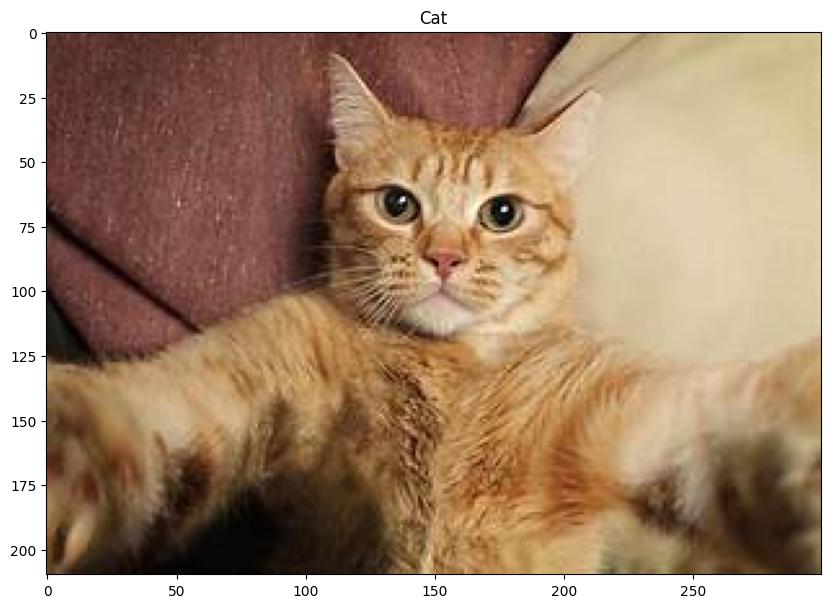

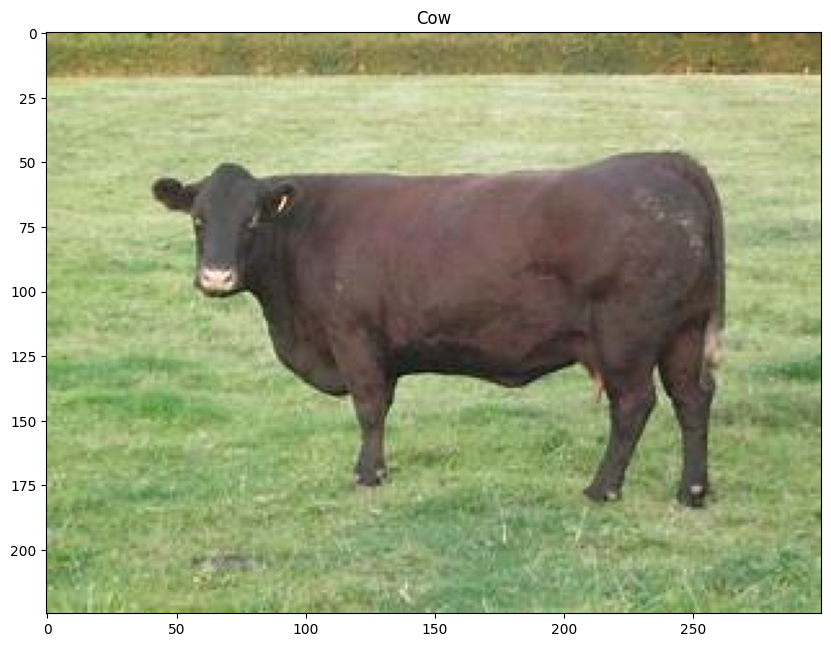

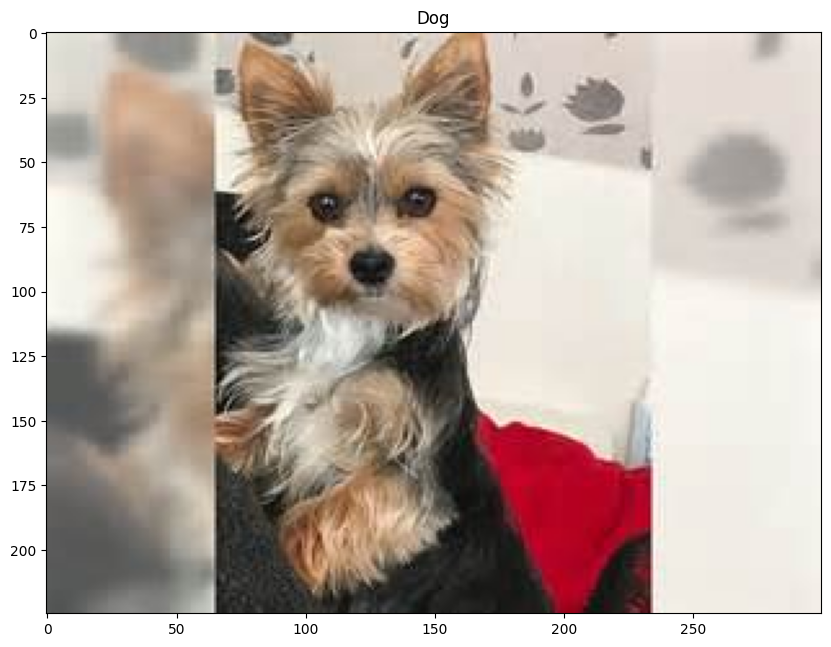

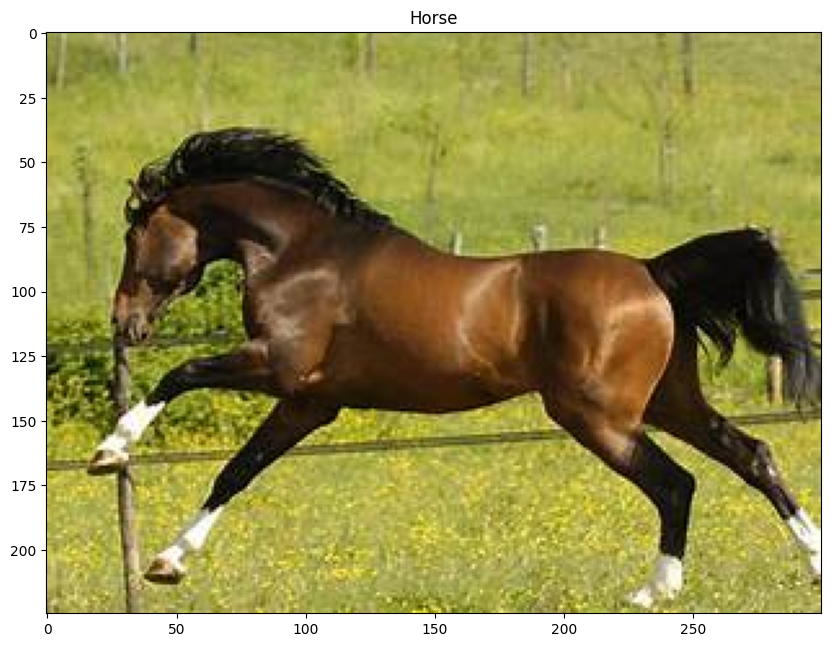

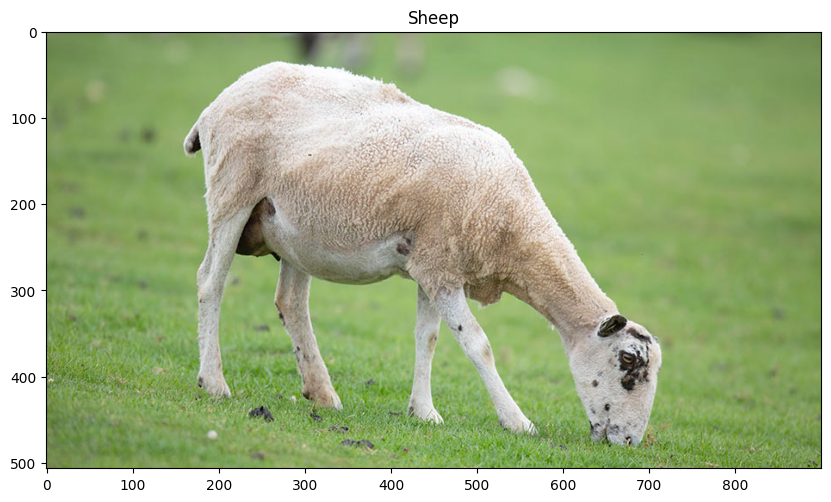

In [889]:
show_image(cat_imgs[0].get_image(), "Cat")
show_image(cow_imgs[0].get_image(), "Cow")
show_image(dog_imgs[0].get_image(), "Dog")
show_image(horse_imgs[0].get_image(), "Horse")
show_image(sheep_imgs[0].get_image(), "Sheep")

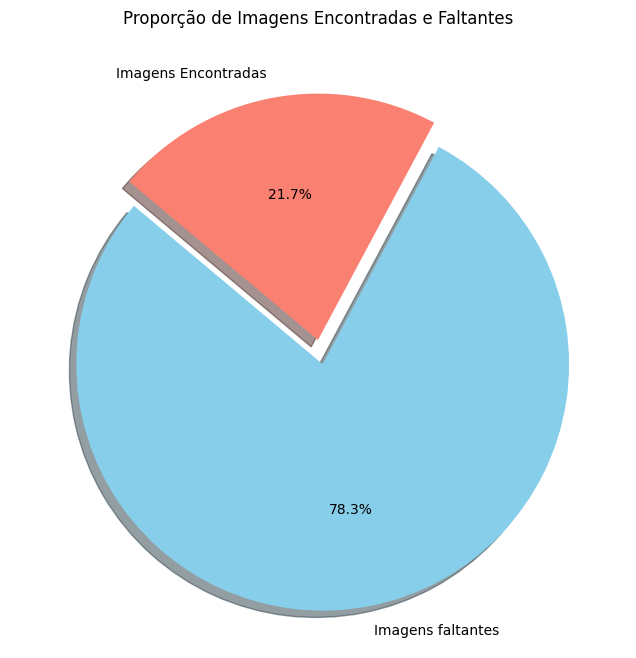

In [890]:
total_images = len(data['images'].keys())
imagens_encontradas = len(imgs_atualizadas)
plot_pie_chart(total_images, imagens_encontradas)

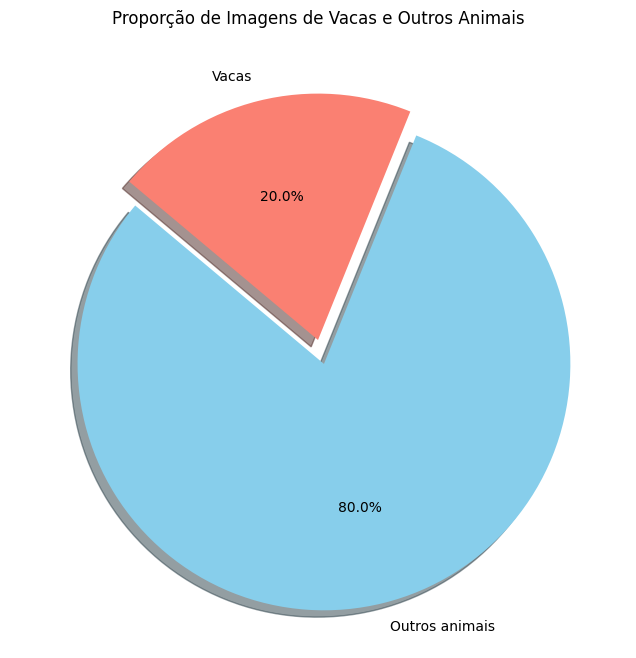

In [891]:
imagens_de_vacas = len(cow_imgs)
plot_pie_chart(imagens_encontradas, imagens_de_vacas, labels=['Outros animais', 'Vacas'], colors=['skyblue', 'salmon'], title='Proporção de Imagens de Vacas e Outros Animais')

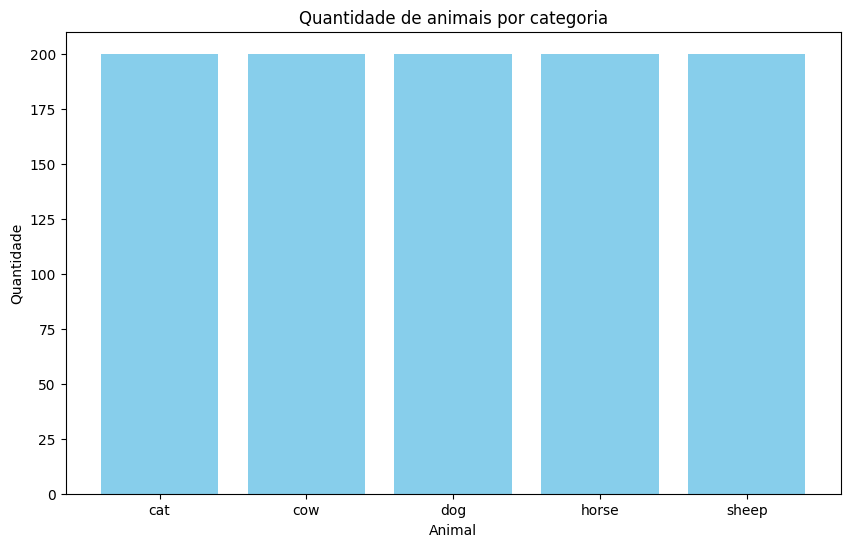

In [892]:
animal_counts = {
  'cat': len(cat_imgs),
  'cow': len(cow_imgs),
  'dog': len(dog_imgs),
  'horse': len(horse_imgs),
  'sheep': len(sheep_imgs)
}

plot_animal_counts(animal_counts)

In [893]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

help(mp_pose.Pose)

Help on class Pose in module mediapipe.python.solutions.pose:

class Pose(mediapipe.python.solution_base.SolutionBase)
 |  Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |
 |  MediaPipe Pose.
 |
 |  MediaPipe Pose processes an RGB image and returns pose landmarks on the most
 |  prominent person detected.
 |
 |  Please refer to https://solutions.mediapipe.dev/pose#python-solution-api for
 |  usage examples.
 |
 |  Method resolution order:
 |      Pose
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Pose object.
 |
 |      Args:
 |        static_image_mode: Whether

In [894]:
def process_and_plot(images):
    """
    Processa as imagens para detecção de pose e exibe as imagens com os pontos de interesse desenhados.

    Args:
    images (list): Lista de objetos Image a serem processados.

    Returns:
    int: Número de imagens processadas com sucesso.
    """
    counter = 0
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
        for image in images:
            # Converte BGR para RGB para o MediaPipe
            results = pose.process(cv2.cvtColor(image.get_resized_image(), cv2.COLOR_BGR2RGB))

            # Ignora se a detecção falhar
            if not results.pose_landmarks:
                continue
            
            plot_with_annotations(image)  # Plota a imagem original com anotações
            
            # Copia a imagem para desenhar os keypoints preditos
            predicted_image = image.get_image().copy()

            mp_drawing.draw_landmarks(
                predicted_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
            )

            counter += 1
            
            # Exibe a imagem com os pontos de interesse
            plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
            plt.title("Imagem predita")
            plt.axis('off')
            plt.show()

    return counter  # Retorna o número de imagens processadas


In [895]:
for img in imgs_atualizadas:
    img.resize_image()

In [896]:
cow_images = filter_by_animal(imgs_atualizadas, 'cow')

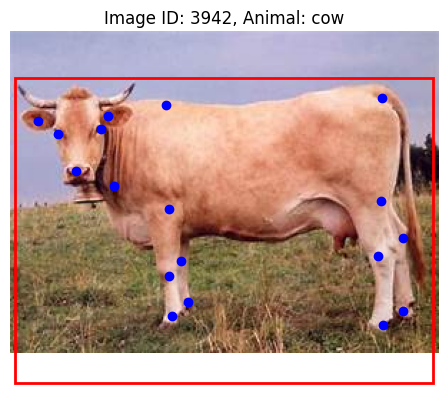

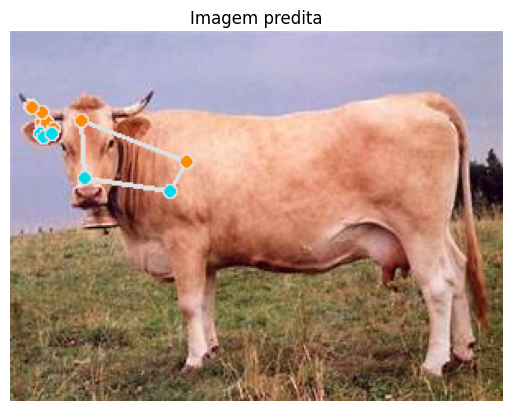

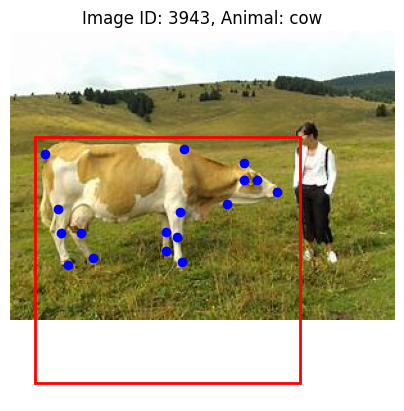

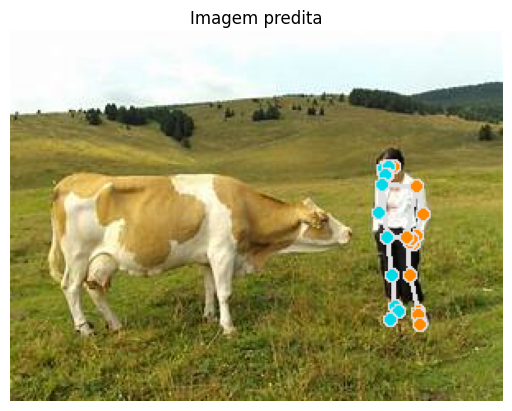

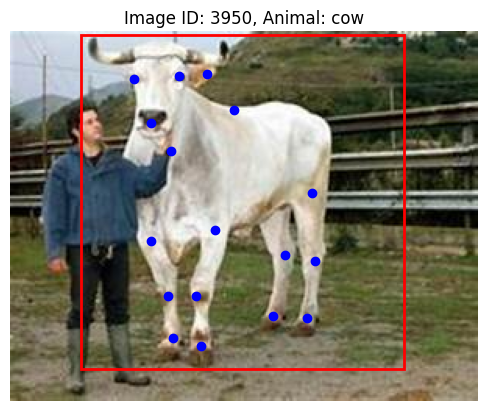

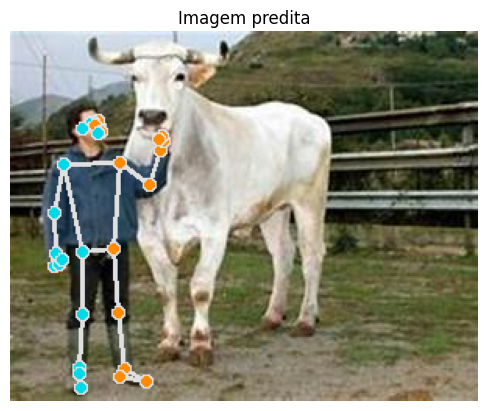

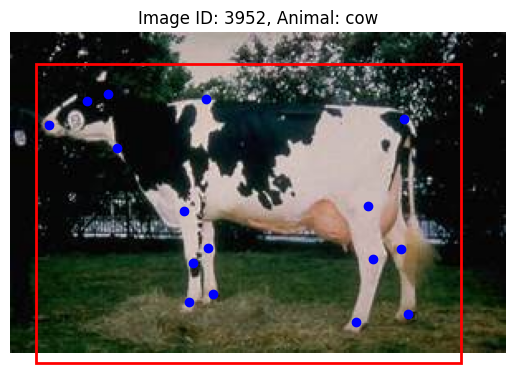

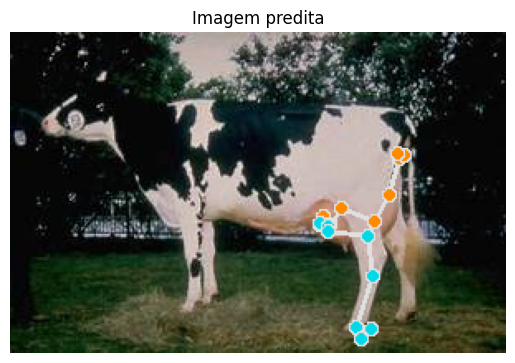

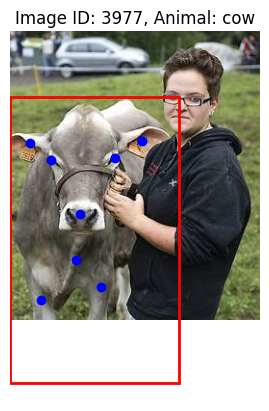

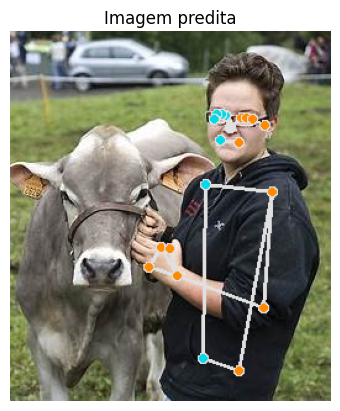

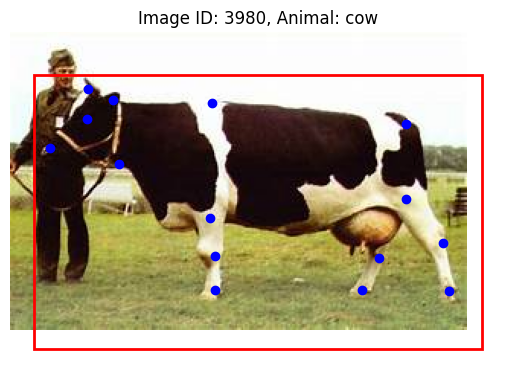

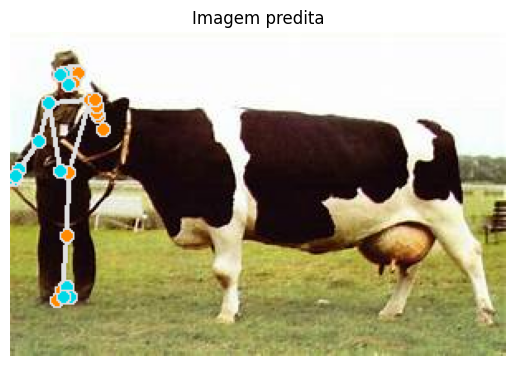

In [897]:
counter = process_and_plot(cow_images)

In [898]:
print(f"Predições encontradas para {counter} imagens com vacas")

Predições encontradas para 6 imagens com vacas
